### Preliminaries
Import all important packages

In [304]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np

import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import chisquare
from sklearn.linear_model import LinearRegression

### Reading and Loading the dataset

In [305]:
file = pd.read_excel('DOH COVID Data Drop_ 20210125.xlsx')
file.head()

,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,ProvRes,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus
0,C724055,36.0,35 to 39,MALE,2020-07-24,2020-07-27,2020-08-01,NaT,2020-08-15,RECOVERED,...,NCR,CITY OF MANILA,PH133908000,NaN,NaN,RECOVERED,NO,NaT,NaN,NaN
1,C164197,41.0,40 to 44,MALE,NaT,NaT,2020-08-25,NaT,NaT,RECOVERED,...,NCR,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco..."
2,C625421,34.0,30 to 34,FEMALE,2020-08-10,2020-08-14,2020-08-20,NaT,NaT,RECOVERED,...,NCR,CITY OF MANILA,PH133900000,NaN,NaN,RECOVERED,NO,NaT,NO,"Removal Type is ""Recovered"", but no Recovered ..."
3,C733334,49.0,45 to 49,MALE,2020-08-07,2020-08-11,2020-08-18,NaT,NaT,RECOVERED,...,LAGUNA,CITY OF CALAMBA,PH043405000,NaN,NaN,RECOVERED,NO,2020-08-01,NaN,"Removal Type is ""Recovered"", but no Recovered ..."
4,C442004,66.0,65 to 69,MALE,2020-10-19,2020-10-22,2020-10-22,NaT,2020-11-14,RECOVERED,...,ILOILO,ILOILO CITY (CAPITAL),PH063022000,NaN,NaN,RECOVERED,NO,2020-10-19,NaN,NaN


### Clean the data :)

In [320]:
file = pd.DataFrame(file)
file1 = file[file['RegionRes']== 'NCR']

file2 = file1.groupby('DateRepConf').size().reset_index()
file2['DateRepConf']=pd.to_datetime(file2['DateRepConf'])
file2['DateRepConf'] = file2['DateRepConf'].dt.strftime('%b %d %Y')
file2[0] = file2[0].cumsum()

file1['DateRepConf'] = pd.to_datetime(file1['DateRepConf']).dt.strftime('%b %d %Y')
stat = []
for i in file1['DateRepConf']:
    stat.append(get_qstatus(i))
file1['Quarantine Status'] = stat
file1.head()

C:\Users\Gelli Mae Gloria\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\Gelli Mae Gloria\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


,CaseCode,Age,AgeGroup,Sex,DateSpecimen,DateResultRelease,DateRepConf,DateDied,DateRecover,RemovalType,...,CityMunRes,CityMuniPSGC,BarangayRes,BarangayPSGC,HealthStatus,Quarantined,DateOnset,Pregnanttab,ValidationStatus,Quarantine Status
0,C724055,36.0,35 to 39,MALE,2020-07-24,2020-07-27,Aug 01 2020,NaT,2020-08-15,RECOVERED,...,CITY OF MANILA,PH133908000,NaN,NaN,RECOVERED,NO,NaT,NaN,NaN,GCQ
1,C164197,41.0,40 to 44,MALE,NaT,NaT,Aug 25 2020,NaT,NaT,RECOVERED,...,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco...",GCQ 2
2,C625421,34.0,30 to 34,FEMALE,2020-08-10,2020-08-14,Aug 20 2020,NaT,NaT,RECOVERED,...,CITY OF MANILA,PH133900000,NaN,NaN,RECOVERED,NO,NaT,NO,"Removal Type is ""Recovered"", but no Recovered ...",GCQ 2
5,C698464,38.0,35 to 39,MALE,NaT,NaT,Jul 24 2020,NaT,NaT,RECOVERED,...,NaN,NaN,NaN,NaN,RECOVERED,NO,NaT,NaN,"Health Status is ""Recovered"", but no Date Reco...",GCQ
6,C565667,33.0,30 to 34,FEMALE,NaT,2020-07-15,Jul 19 2020,NaT,NaT,RECOVERED,...,CITY OF NAVOTAS,PH137503000,NaN,NaN,RECOVERED,NO,NaT,NO,"Health Status is ""Recovered"", but no Date Reco...",GCQ


We define a function to get the Quarantine Status for each day

In [464]:
date_format = '%b %d %Y'
date_start = ['Mar 06 2020', 'Mar 15 2020', 'Apr 01 2020', 'May 01 2020', 'May 16 2020','Jun 01 2020', 'Jul 01 2020', 'Aug 01 2020', 'Aug 04 2020', 'Aug 19 2020', 'Sep 01 2020', 'Oct 01 2020', 'Nov 01 2020', 'Dec 01 2020', 'Jan 01 2021']
date_end = ['Mar 14 2020', 'Mar 31 2020', 'Apr 30 2020', 'May 15 2020', 'May 31 2020','Jun 30 2020', 'Jul 31 2020', 'Aug 03 2020', 'Aug 18 2020', 'Aug 31 2020', 'Sep 30 2020', 'Oct 31 2020', 'Nov 30 2020', 'Dec 31 2020', 'Jan 25 2021']

def get_qstatus(date):
    if date_start[0] <= date <= date_end[0]:
        return 'Before Quarantine'
    elif date_start[1] <= date <= date_end[1] or date_start[2] <= date <= date_end[2] or date_start[3] <= date <= date_end[3]:
        return "ECQ"
    elif date_start[4] <= date <= date_end[4]:
        return "MECQ"
    elif date_start[5] <= date <= date_end[5] or date_start[6] <= date <= date_end[6] or date_start[7] <= date <= date_end[7]:
        return "GCQ"
    elif date_start[8] <= date <= date_end[8]:
        return "MECQ 2"
    elif date_start[9] <= date <= date_end[9] or date_start[10] <= date <= date_end[10] or date_start[11] <= date <= date_end[11] or date_start[12] <= date <= date_end[12] or date_start[13] <= date <= date_end[13] or date_start[14] <= date <= date_end[14]:
        return "GCQ 2"
    return

In [328]:
q_stat = []
for i in file2['DateRepConf']:
    q_stat.append(get_qstatus(i))

file3 = file2.copy()
file3['count']=file3[0]
file3['Quarantine Status'] = q_stat
#file3['DateRepConf'] = pd.to_datetime(file3['DateRepConf']).strftime('%Y-%m-%d')
date = []
for i in pd.to_datetime(file3['DateRepConf']).dt.strftime('%Y-%m-%d'):
    date.append(dt.strptime(i,'%Y-%m-%d').toordinal())
file3['ordinal']=date
day = file1.groupby('DateRepConf').size().reset_index()
file3['Daily'] = day[0]

file3.to_excel('important.xlsx')
file3.tail()

,DateRepConf,0,count,Quarantine Status,ordinal,Daily
320,Jan 21 2021,218019,218019,GCQ 2,737811,1112
321,Jan 22 2021,218623,218623,GCQ 2,737812,1047
322,Jan 23 2021,219005,219005,GCQ 2,737813,1152
323,Jan 24 2021,219425,219425,GCQ 2,737814,597
324,Jan 25 2021,219756,219756,GCQ 2,737815,867


### Visualizatiooooons

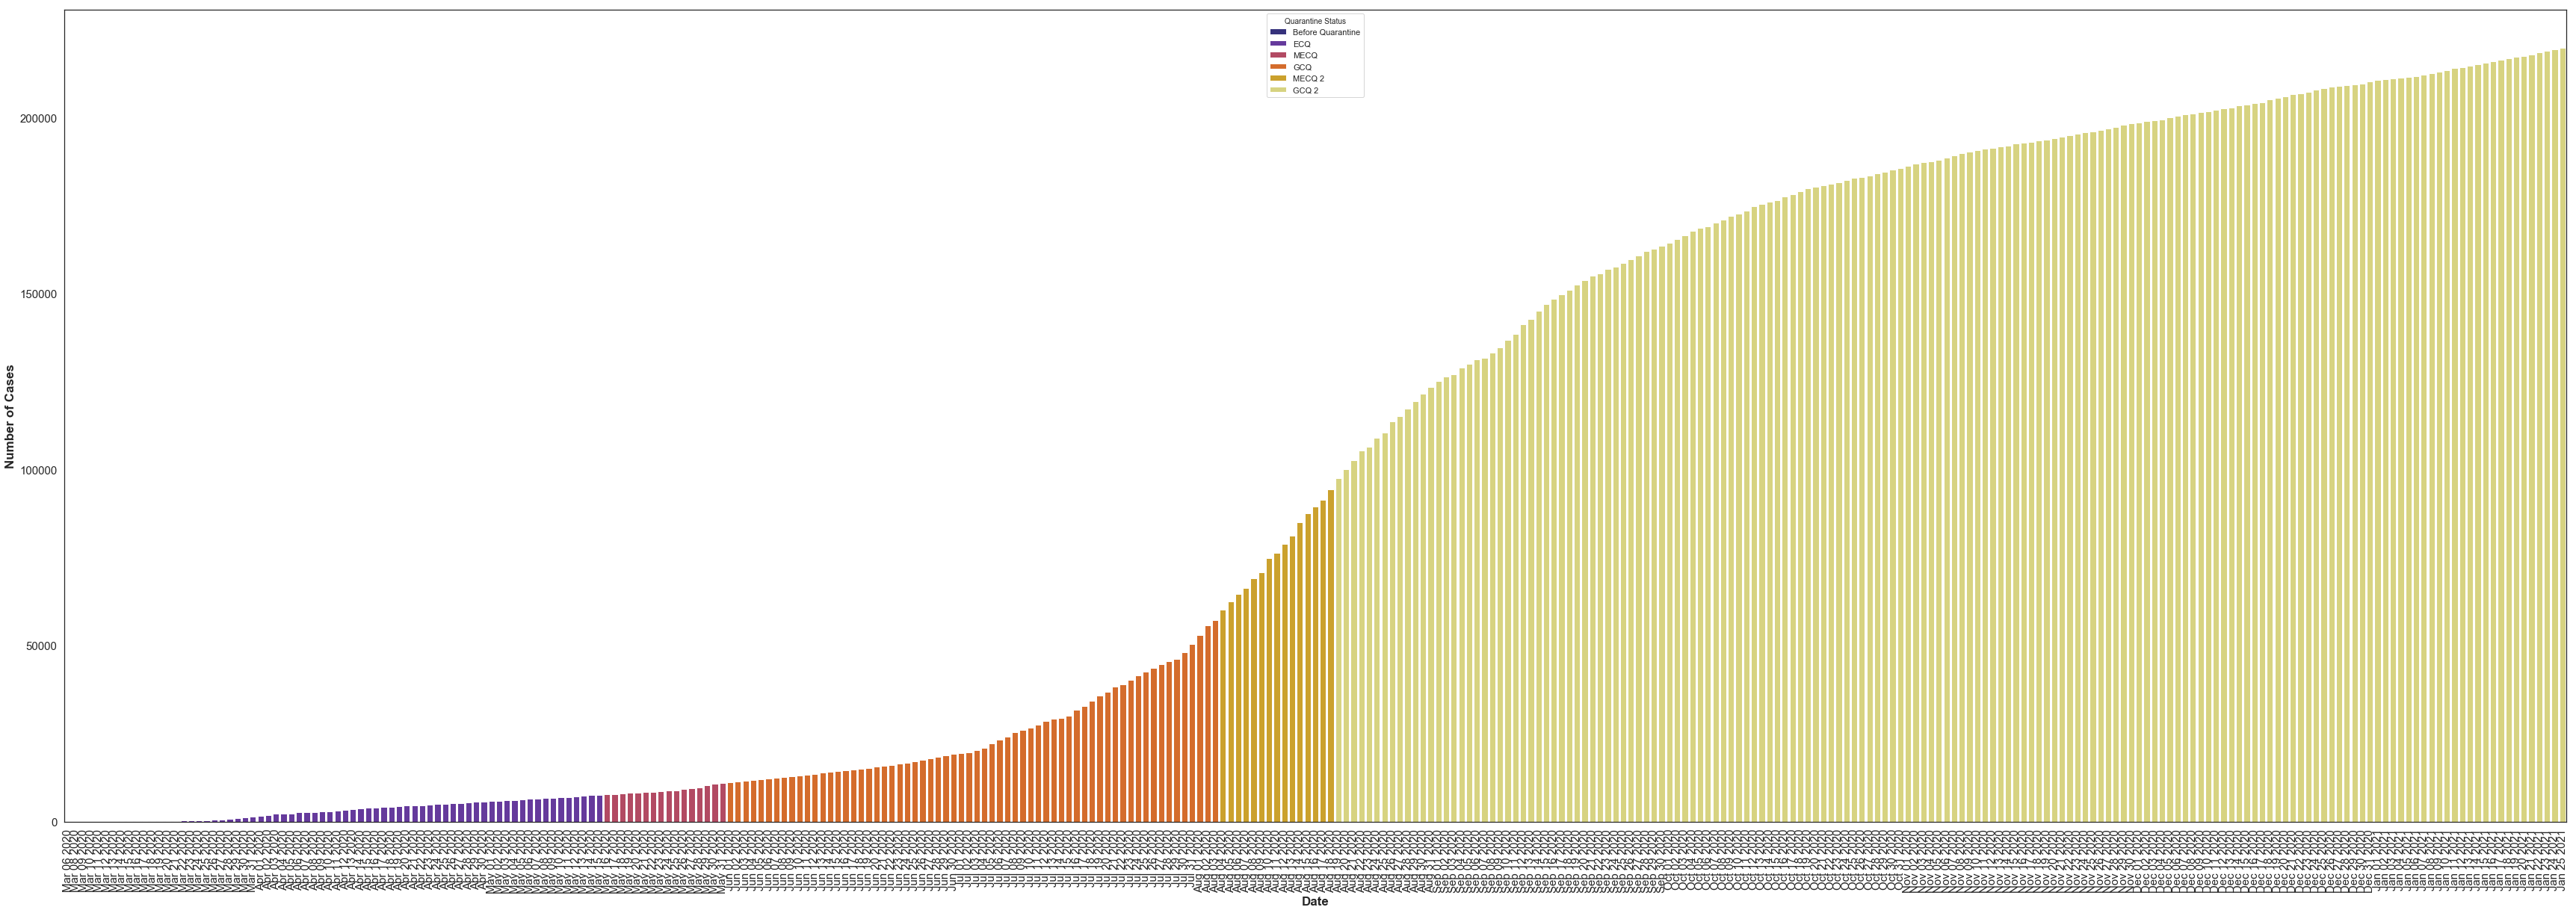

In [326]:
sns.set(rc={'figure.figsize':(60,20)})
sns.set_style('white')
plot = sns.barplot(data=file3, x='DateRepConf', y='count',hue='Quarantine Status', hue_order = ['Before Quarantine', 'ECQ', 'MECQ','GCQ', 'MECQ 2', 'GCQ 2'], palette="CMRmap", dodge=False) 
plt.xlabel('Date',fontweight='bold', fontsize = 17)
plt.ylabel('Number of Cases',fontweight='bold', fontsize = 17)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plot.set_xticklabels(file2['DateRepConf'], rotation = '90')

plt.savefig('bar.png')

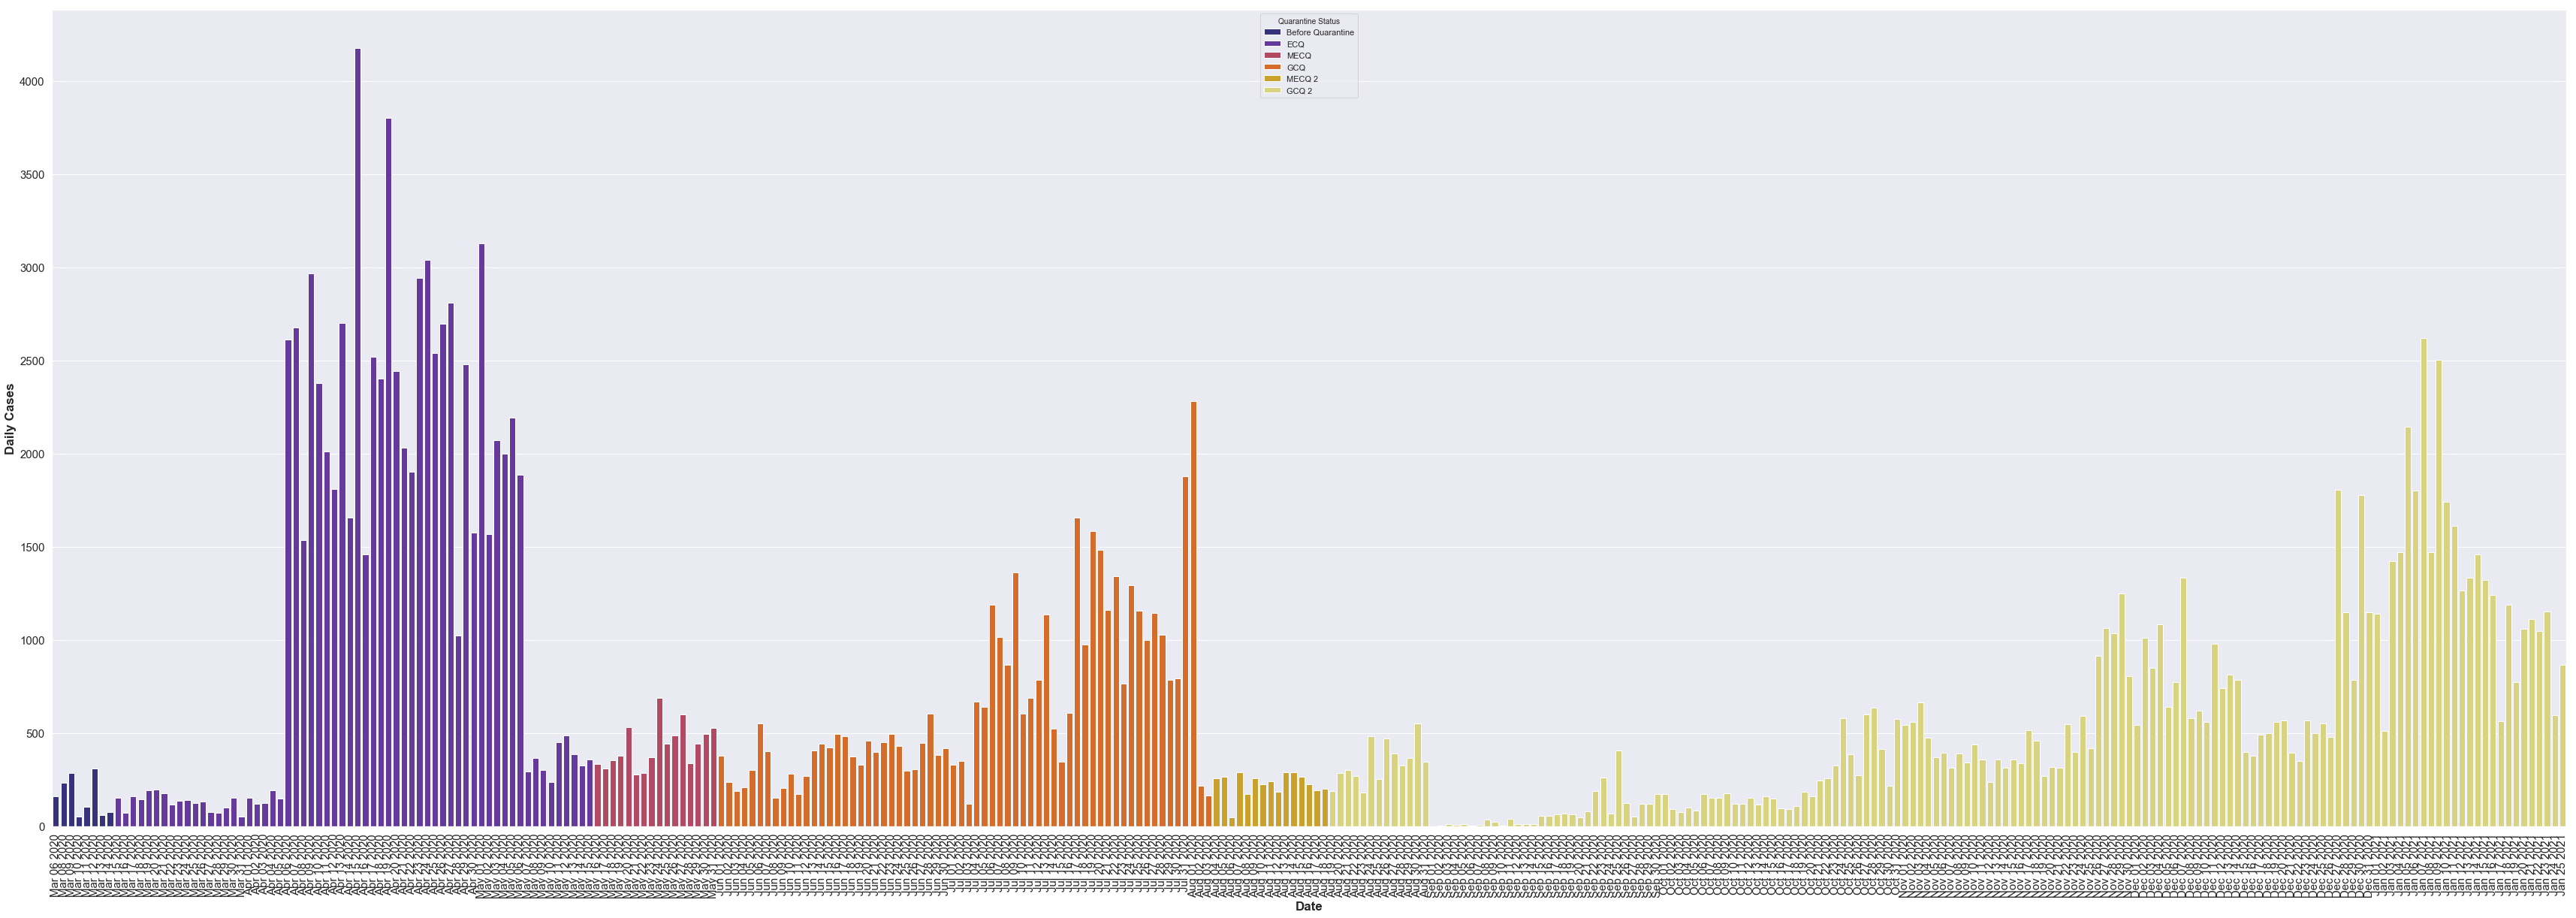

In [396]:
sns.set_style('white')
sns.set(rc={'figure.figsize':(60,20)})
plot = sns.barplot(data=file3, x='DateRepConf', y='Daily',hue='Quarantine Status', hue_order = ['Before Quarantine', 'ECQ', 'MECQ','GCQ', 'MECQ 2', 'GCQ 2'], palette="CMRmap", dodge=False)
plt.xlabel('Date',fontweight='bold', fontsize = 17)
plt.ylabel('Daily Cases',fontweight='bold', fontsize = 17)

plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plot.set_xticklabels(file2['DateRepConf'], rotation = '90')

plt.savefig('daily.png')

C:\Users\Gelli Mae Gloria\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


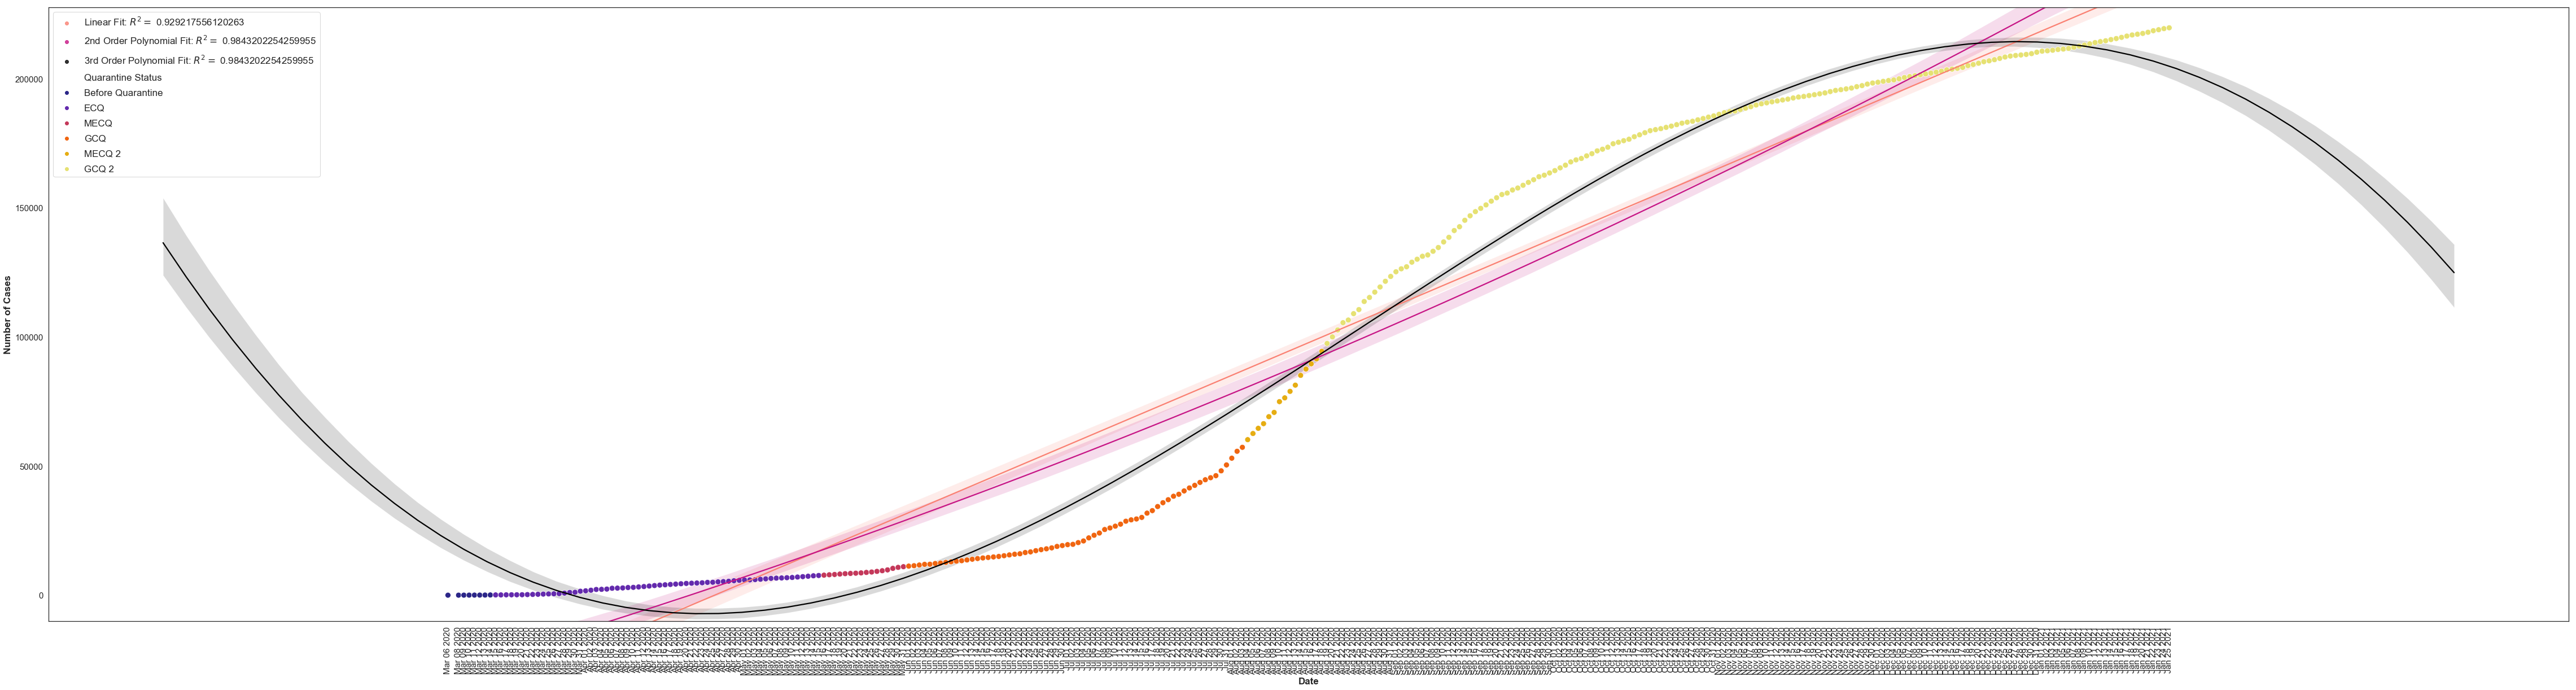

In [373]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import numpy as np

sns.set(rc={'figure.figsize':(80,20)})
sns.set_style('white')

x = np.array(file3['ordinal']).reshape((-1, 1))
y = np.array(file3['count']).reshape((-1, 1))
# scipy.optimize.curve_fit(lambda t,a,b: a*np.log(b*t),  x,  y)

# linear regression
linreg = LinearRegression()
linreg.fit(x,y)
lin_eq = ["$R^2 =$", str(linreg.score(x,y))]

# polynomial reg (degree = 2)
p2 = np.polyfit(list(file3['ordinal']), file3['count'], 2)
poly2 = PolynomialFeatures(degree = 2)
y2_predict = np.polyval(p2,x)
poly2_eq = ["$R^2 =$", str(r2_score(y,y2_predict))]

# polynomial reg (degree = 3)
p3 = np.polyfit(list(file3['ordinal']), file3['count'], 3)
y3_predict = np.polyval(p3,x)
poly2_eq = ["$R^2 =$", str(r2_score(y,y3_predict))]

order1 = sns.regplot(data = file3, x='ordinal', y='count', order=1, color='salmon', label="Linear Fit: " + " ".join(lin_eq))
order2 = sns.regplot(data = file3, x='ordinal', y='count', order=2, color='mediumvioletred', label="2nd Order Polynomial Fit: " + " ".join(poly2_eq))
order3 = sns.regplot(data = file3, x='ordinal', y='count', order=3, color='black', label="3rd Order Polynomial Fit: " + " ".join(poly3_eq))
plot = sns.scatterplot(data=file3, x='ordinal', y='count',hue='Quarantine Status', palette="CMRmap", s = 100) 

plt.xlabel('Date',fontweight='bold', fontsize = 17)
plt.ylabel('Number of Cases',fontweight='bold', fontsize = 17)

plt.xticks(file3['ordinal'], file3['DateRepConf'], fontsize=15,  rotation = '90')
# plot.set_xticklabels(file3['DateRepConf'], rotation = '90')
plt.legend(labelspacing=0.7,  prop={'size': 17}, facecolor='white')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.ylim([-10000, y[-1] + 8000 ])

plt.savefig('fitting.png')

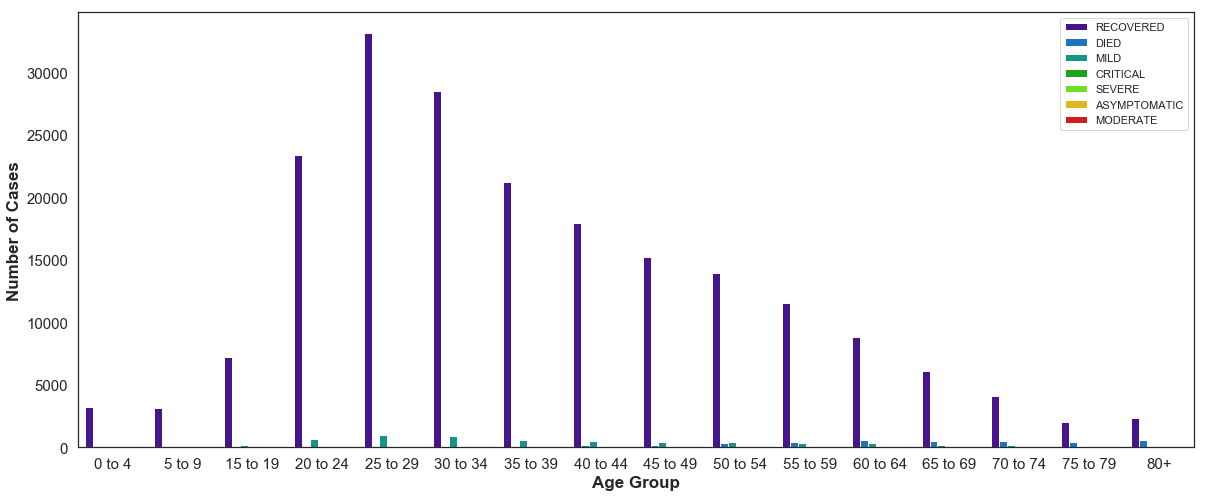

In [389]:
sns.set(rc={'figure.figsize':(20,8)})
sns.set_style('white')
sns.countplot(data=file1, x = 'AgeGroup', order = ['0 to 4', '5 to 9', '15 to 19', '20 to 24', '25 to 29', '30 to 34',
                                                    '35 to 39', '40 to 44', '45 to 49', '50 to 54', '55 to 59', '60 to 64',
                                                   '65 to 69', '70 to 74', '75 to 79', '80+']
              , hue = 'HealthStatus', palette = 'nipy_spectral')
plt.xlabel('Age Group',fontweight='bold', fontsize = 17)
plt.ylabel('Number of Cases',fontweight='bold', fontsize = 17)
plt.legend(loc='upper right')
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.savefig('CountvsAgeGroup.png')

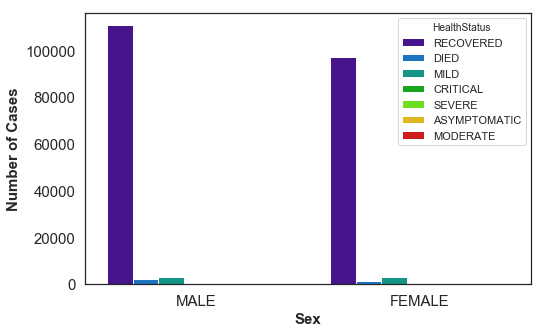

In [388]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('white')
sns.countplot(data=file1, x = 'Sex', hue = 'HealthStatus', palette = 'nipy_spectral')
plt.xlabel('Sex',fontweight='bold', fontsize = 15)
plt.ylabel('Number of Cases',fontweight='bold', fontsize = 15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.savefig('CountvsSex_hue_healthstatus.png')

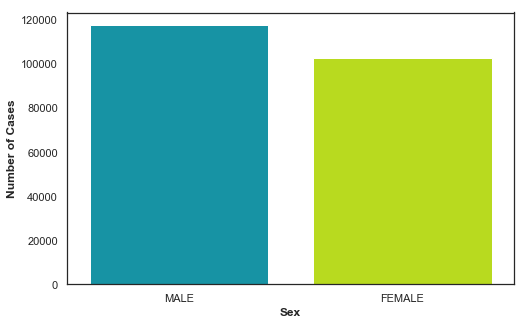

In [383]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('white')

sns.countplot(data=file1, x = 'Sex', palette = 'nipy_spectral')

plt.xlabel('Sex',fontweight='bold')
plt.ylabel('Number of Cases',fontweight='bold')
plt.savefig('CountvsSex.png')

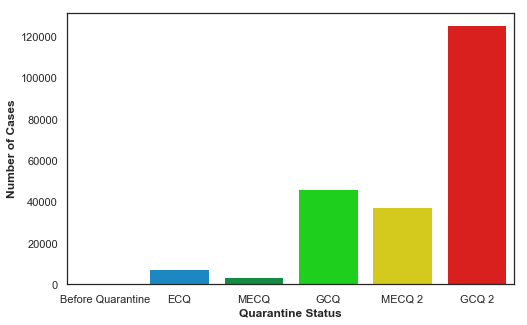

In [384]:
sns.set(rc={'figure.figsize':(8,5)})
sns.set_style('white')

sns.countplot(data=file1, x = 'Quarantine Status', order = ['Before Quarantine', 'ECQ', 'MECQ','GCQ', 'MECQ 2','GCQ 2'], palette = 'nipy_spectral')

plt.xlabel('Quarantine Status',fontweight='bold')
plt.ylabel('Number of Cases',fontweight='bold')
plt.savefig('CountvsQstat.png')

### Chi-square Test
Using the equation from the reference: John R. Taylor's Introduction to Error Analysis (2nd Edition).

$\tilde{\chi}^2 = \frac{1}{d}\sum_{k=1}^{n}\frac{(O_k - E_k)^2}{E_k},$

we can obtain the relationships we are interested in.

In [449]:
p3 = np.polyfit(list(file3['ordinal']), file3['count'], 3)
y3_predict = np.polyval(p3,x)

y2 = y2_predict.flatten()
y1 = linreg.predict(x)
y3 = y3_predict.flatten()
expected = y3
observed = y
chi_each = [np.abs(i[0]-i[1])**2/i[1] for i in zip(observed,expected)]
chi = np.sum(chi_each)
chi

-1358037.868207537

In [439]:
df2 = pd.crosstab(y3.flatten(),file3['count'],margins=False)
chi, p, dof, arr = chi2_contingency(df2)
print('{}\nchi-square={}, p-value={}, dof={}'.format(df2,chi,p,dof))

count      1       3       14      21      33      35      44      80      \
row_0                                                                       
-7176.0         0       0       0       0       0       0       0       0   
-7160.0         0       0       0       0       0       0       0       0   
-7150.0         0       0       0       0       0       0       0       0   
-7120.0         0       0       0       0       0       0       0       0   
-7104.0         0       0       0       0       0       0       0       0   
-7056.0         0       0       0       0       0       0       0       0   
-7036.0         0       0       0       0       0       0       0       0   
-6970.0         0       0       0       0       0       0       0       0   
-6950.0         0       0       0       0       0       0       0       0   
-6862.0         0       0       0       0       0       0       0       0   
-6844.0         0       0       0       0       0       0       0       0   

In [463]:
df2 = pd.crosstab(file1['Sex'],file1['HealthStatus'],margins=False)
chi, p, dof, arr = chi2_contingency(df2)
df2_exp = pd.DataFrame({'Asymptomatic': arr[:,0], 'Critical': arr[:,1],\
            'Died': arr[:,2], 'Mild': arr[:,3], 'Recovered': arr[:,4],\
                'Severe': arr[:,5]}, index=['Female', 'Male'])
print('{}\nchi-square={}, p-value={}, dof={}'.format(df2_exp,chi,p,dof))

df2 = pd.crosstab(file1['AgeGroup'],file1['Sex'],margins=False)
chi, p, dof, arr = chi2_contingency(df2)
# df2_exp = pd.DataFrame({'Before Quarantine': arr[:,0], 'ECQ': arr[:,1],\
#             'MECQ': arr[:,2], 'GCQ': arr[:,3], 'MECQ 2': arr[:,4],\
#                 'GCQ 2': arr[:,5]})
print('{}\nchi-square={}, p-value={}, dof={}'.format(df2,chi,p,dof))

        Asymptomatic    Critical         Died         Mild  Recovered  \
Female    100.766778  416.129471  1867.450977  2958.158043  17.727489   
Male      115.233222  475.870529  2135.549023  3382.841957  20.272511   

               Severe  
Female   96999.686357  
Male    110925.313643  
chi-square=97.39282989344056, p-value=8.77428296725909e-19, dof=6
Sex       FEMALE   MALE
AgeGroup               
0 to 4      1524   1855
10 to 14    2110   2294
15 to 19    3839   3660
20 to 24   12148  11998
25 to 29   16137  18169
30 to 34   13119  16409
35 to 39    9574  12435
40 to 44    7973  10751
45 to 49    7007   8992
5 to 9      1530   1712
50 to 54    6753   8034
55 to 59    5951   6550
60 to 64    4913   4949
65 to 69    3517   3566
70 to 74    2476   2455
75 to 79    1422   1196
80+         1883   1294
chi-square=889.6233064055101, p-value=4.596519837312119e-179, dof=16
